##**Clasificación de masas cencerígenas, realizado por Isabela Luján y Daniel Naranjo**
 

## Importe de librerías necesarias

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

##Subida y revisón de los datos

El dataframe fue enviado con el .ipybn, en caso de que haya problemas en este link se encuentra la carpeta con el dataframe: https://drive.google.com/drive/folders/1mic1HCSvySvBCG6vQXVVWFu8SH540rm2?usp=sharing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving mammographic_masses.csv to mammographic_masses.csv


In [3]:
import io
mamm_masses = pd.read_csv(io.BytesIO(uploaded["mammographic_masses.csv"]))

In [4]:
mamm_masses.shape

(961, 6)

In [5]:
mamm_masses.groupby('Severidad').size()

Severidad
0    516
1    445
dtype: int64

#Preprocesamiento de los datos
Primero, se analiza si es necesario preprocesar los datos de alguna manera antes de proceder con la creación del árbol de decisiones y los respectivos analisis.

In [6]:
mamm_masses.head()

,Mamografia,Edad,Forma,Margen,Densidad,Severidad
0,5,67,3,5,3,1
1,4,43,1,1,76,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,76,1


Se buca si en el dataframe existen datos nulos o filas incompletas

In [7]:
is_NaN = mamm_masses.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = mamm_masses[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [Mamografia, Edad, Forma, Margen, Densidad, Severidad]
Index: []


Como se puede ver no hay ninguna fila que tenga datos faltantes. Sin embargo, el dataframe no es perfecto, pues a pesar de que se supone todos los datos están en rangos definidos, hay valores que se salen de la escala en la mayoría de las variables

In [8]:
# Valores fuera de rango en la columna de Densidad
aux1 = 0 
aux2 = 0
for valor in mamm_masses["Densidad"]:
  if valor > 4 or valor < 1:
    if valor == 76:
      aux1 += 1
    else:
      aux2 += 1
print("El numero fuera de rango fue 76 con un total de", aux1, "apariciones")
print("El numero fuera de rango fue diferente de 76 con un total de", aux2, "apariciones")

El numero fuera de rango fue 76 con un total de 76 apariciones
El numero fuera de rango fue diferente de 76 con un total de 0 apariciones


In [9]:
# Valores fuera de rango en la columna de Forma
aux1 = 0 
aux2 = 0
for valor in mamm_masses["Forma"]:
  if valor > 4 or valor < 1:
    if valor == 31:
      aux1 += 1
    else:
      aux2 += 1
print("El numero fuera de rango fue 31 con un total de", aux1, "apariciones")
print("El numero fuera de rango fue diferente de 31 con un total de", aux2, "apariciones")

El numero fuera de rango fue 31 con un total de 31 apariciones
El numero fuera de rango fue diferente de 31 con un total de 0 apariciones


In [10]:
# Valores fuera de rango en la columna de Margen
aux1 = 0 
aux2 = 0
for valor in mamm_masses["Margen"]:
  if valor > 5 or valor < 1:
    if valor == 48:
      aux1 += 1
    else:
      aux2 += 1
print("El numero fuera de rango fue 48 con un total de", aux1, "apariciones")
print("El numero fuera de rango fue diferente de 48 con un total de", aux2, "apariciones")

El numero fuera de rango fue 48 con un total de 48 apariciones
El numero fuera de rango fue diferente de 48 con un total de 0 apariciones


Luego de estudiar el dataframe se encontró que había algunos datos fuera de los rangos establecidos y que el valor era siempre el mismo, demás no encontramos ninguna relación entre el dato erroneo y las demás columnas.

In [11]:
# Valores fuera de rango en la columna de Margen
aux1 = 0 
aux2 = 0
aux3 = 0
for valor in mamm_masses["Mamografia"]:
  if valor > 5 or valor < 1:
    if valor == 55:
      aux1 += 1
    elif valor == 6:
      aux2 += 1
    elif valor == 0:
      aux3 += 1
    else:
      print("El numero fuera de rango es:", valor, "y es diferente de 0, 6 y 55")
print("El numero fuera de rango fue 55 con un total de", aux1, "apariciones")
print("El numero fuera de rango fue 6 con un total de", aux2, "apariciones")
print("El numero fuera de rango fue 0 con un total de", aux3, "apariciones")

El numero fuera de rango fue 55 con un total de 1 apariciones
El numero fuera de rango fue 6 con un total de 11 apariciones
El numero fuera de rango fue 0 con un total de 5 apariciones


In [12]:
# Reemplazo de valores fuera del rango establecido en la columna de Mamografia
mamm_masses["Mamografia"].replace({55: 5}, inplace=True)
mamm_masses["Mamografia"].replace({0: 1}, inplace=True)
mamm_masses["Mamografia"].replace({6: 5}, inplace=True)

En el caso de la columna de la mamografía se hallaron 3 valores diferentes entre los datos erroneos, un era un 55 y llegamos a la conclusión de que fue un error de escritura por lo que lo reemplazamos por un 5, el otro era el 0 por lo que se aproximó a 1 y el último era el 6 por lo que se aproximó a 5.

In [13]:
# Reemplazo de valores fuera del rango establecido en la columna de Densidad

mamm_masses["Densidad"].replace({76: int(mamm_masses['Densidad'].mode())}, inplace=True)

In [14]:
# Reemplazo de valores fuera del rango establecido en la columna de Forma

mamm_masses["Forma"].replace({31: int(mamm_masses['Forma'].mode())}, inplace=True)

In [15]:
# Reemplazo de valores fuera del rango establecido en la columna de Margen

mamm_masses["Margen"].replace({48: int(mamm_masses['Margen'].mode())}, inplace=True)

Procedemos a reemplazar los datos erroneos de las demás columnas por la moda de para la respectiva categoría.



In [16]:
#Revisión de corección de datos
for valor in mamm_masses["Densidad"]:
  if valor > 4:
    print(valor)

for valor in mamm_masses["Forma"]:
  if valor > 4:
    print(valor)

for valor in mamm_masses["Margen"]:
  if valor > 5:
    print(valor)

aux1 = 0 
for valor in mamm_masses["Mamografia"]:
  if valor > 5 or valor < 1:
    print("El numero fuera de rango fue", valor, "con un total de", aux1, "apariciones")

Estos ciclos for no imprimen nada, lo que significa que los valores del dataframe ya están dentro de los rangos establecidos.

#Visualización de los datos

A continuación se harán ciertas gráficas para mostrar la distribución y el comprtamiento de las distintas variables de entrada.

##Respecto a la edad
Al graficar las edades registradas en el dataset se obtuvo la siguiente gráfica:

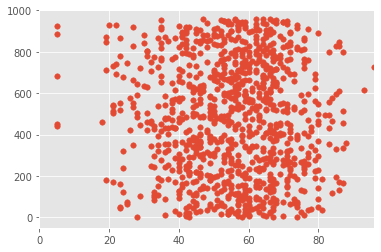

In [17]:
f1 = mamm_masses['Edad'].values
f2 = mamm_masses.index

plt.scatter(f1, f2, s=30)
plt.axis([0,mamm_masses['Edad'].max(), -50, 1000])
plt.show()

In [18]:
Edad_minima = mamm_masses['Edad'].min()
Edad_maxima = mamm_masses['Edad'].max()
print("La menor edad de una persona que se realizó la mamografía es de: ", Edad_minima, "años.")
print("La mayor edad de una persona que se realizó la mamografía es de: ", Edad_maxima, "años.")

La menor edad de una persona que se realizó la mamografía es de:  5 años.
La mayor edad de una persona que se realizó la mamografía es de:  96 años.


Con todo lo anterior podemos conluir que la mayoría de las mujeres que se realizaron el examen se encuentran entre los 40 y 80 años de edad, cosa lógica, pues la mamografía es un examen recomendado de manera anual para las mujeres a partir de los 40 y puede realizarse en mujeres más jovenes si ellas o su médico lo creen necesario.

A su vez tenemos que hay unos cuantos datos atipicos que representan niñas de alrededor de los 5 años, las cuales si bien al principio pueden dar la sensación de ser un error, se dejarán en el dataset pues es posible que hayan sufrido sintomas de cáncer de mama a pesar de su corta edad o que el exámen les haya sido diagnosticado debido a alguna otra enfermedad o procedimiento anterior, como procedimientos que requieran el uso de radiación en el área toráxica [2].

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


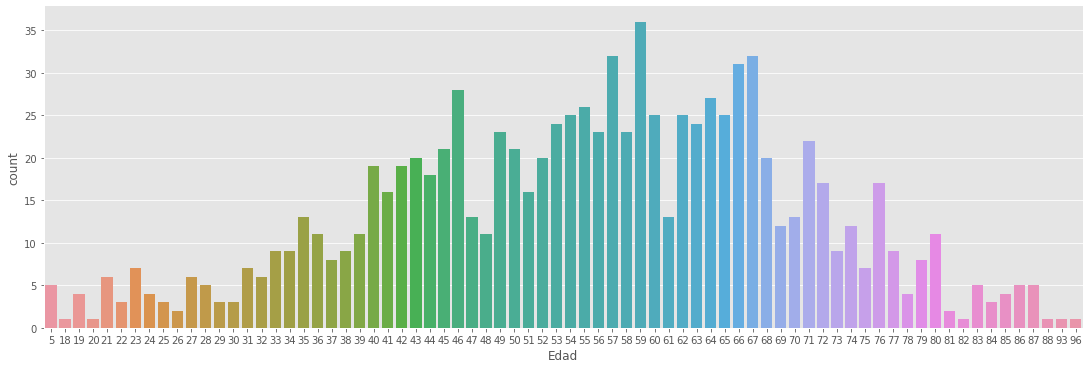

In [19]:
sb.factorplot('Edad',data=mamm_masses,kind="count", aspect=3)

Agrupamos por rango de edad para normalizar los datos.

In [20]:
#Mapping edad
mamm_masses_age = mamm_masses['Edad']

mamm_masses.loc[ mamm_masses_age <= 20, 'RangoEdad'] = 1
mamm_masses.loc[(mamm_masses_age > 20) & (mamm_masses_age <= 35), 'RangoEdad'] = 2
mamm_masses.loc[(mamm_masses_age > 35) & (mamm_masses_age <= 50), 'RangoEdad'] = 3
mamm_masses.loc[(mamm_masses_age > 50) & (mamm_masses_age <= 65), 'RangoEdad'] = 4
mamm_masses.loc[(mamm_masses_age > 65) & (mamm_masses_age <= 80), 'RangoEdad'] = 5
mamm_masses.loc[(mamm_masses_age > 80), 'RangoEdad'] = 6

Y se grafica para ver la distribució nde la nueva variable

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


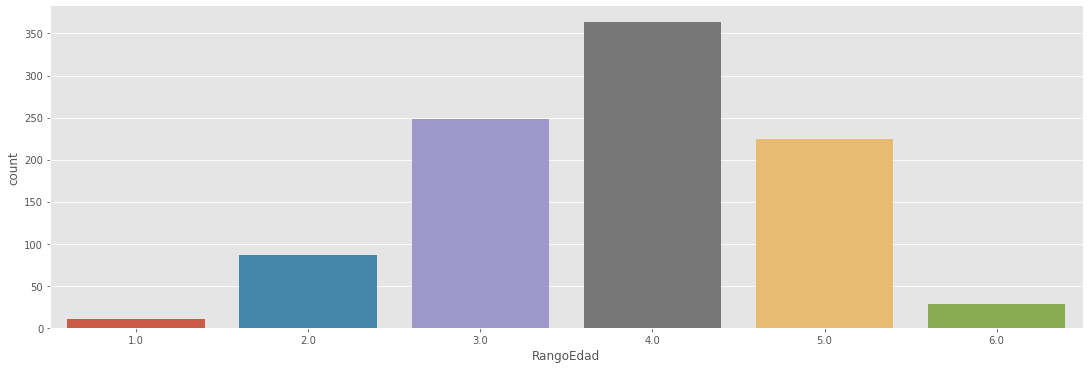

In [21]:
sb.factorplot('RangoEdad',data=mamm_masses,kind="count", aspect=3)

1. Entre 0 y 20 años
2. Entre 21 y 35 años
3. Entre 36 y 50 años
4. Entre 51 y 65 años
5. Entre 66 y 80 años
6. De 81 años para arriba

##Respecto a las demás variales

###Mamografía

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


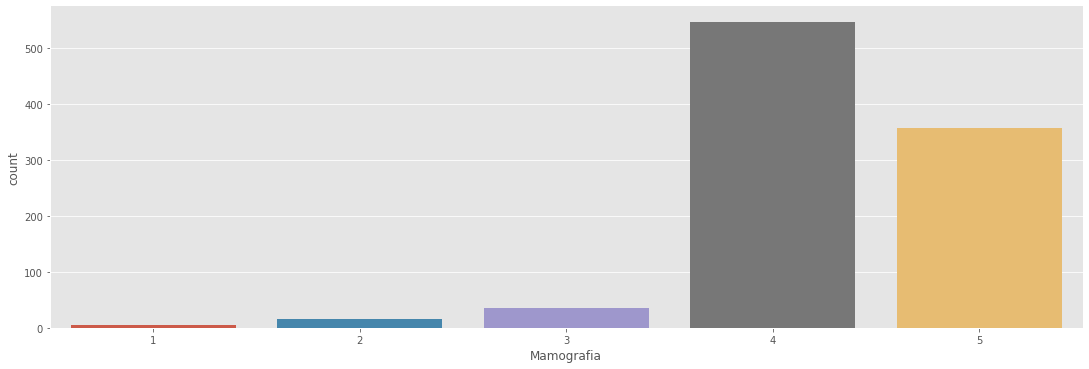

In [22]:
sb.factorplot('Mamografia',data=mamm_masses,kind="count", aspect=3)

Basados en el documentos de los atributos y al hacer algunas consultas en ionternet, se encontró que posiblemente sea una representación de las categorías BI-RADS [1], usadas para la clasificación de los resultados de las mamografías:

1. Hallazgo negativo
2. Hallazgo benigno (no canceroso)
3. Hallazgo posiblemente benigno, se recomienda seguimiento a corto plazo
4. Anomalía sospechosa, se debe considerar una biopsia
5. Anomalía que sugiere altamente un hallazgo maligno. Se deben tomar las acciones adecuadas.

###Forma

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


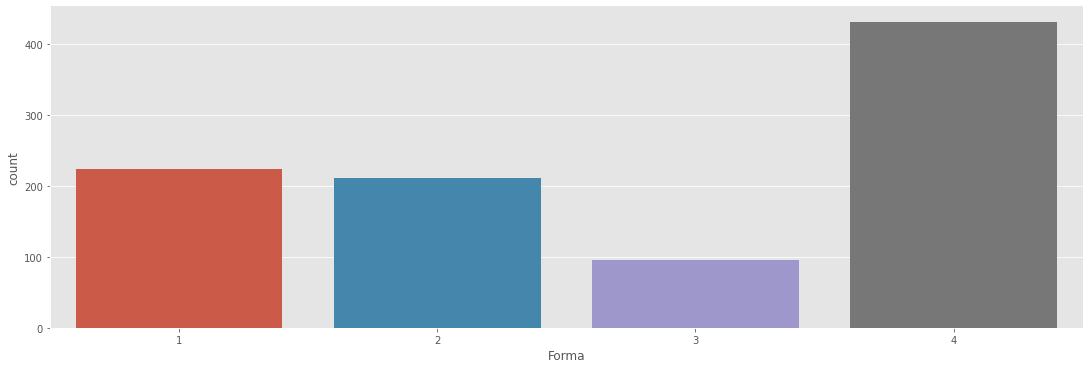

In [23]:
sb.factorplot('Forma',data=mamm_masses,kind="count", aspect=3)
#forma de la masa: round=1 oval=2 lobular=3 irregular=4

Esta gráfica permite ver como se distribuye la forma de las mamas evaluadas al hacer el exámen:
1. Redonda
2. Ovalada
3. Lobulillar
4. Irregular

Siendo las 2 primeras evidencias de normalidad y las dos ultimas aspectos anómalos que hay que tener en cuenta en el diagnostico, dejandonos esto evidenciar una preocupante predominancia por parte de las irregulares sobre las demás clasificaciones.

###Margen

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


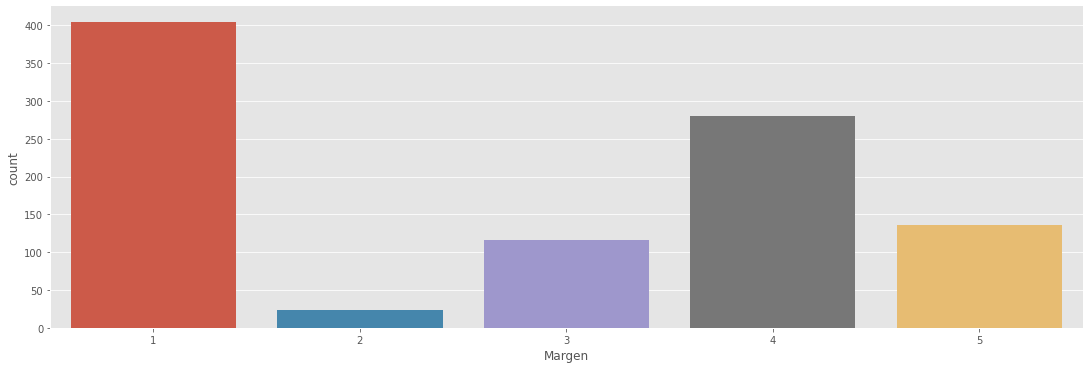

In [24]:
sb.factorplot('Margen',data=mamm_masses,kind="count", aspect=3)
#Margen: margen de la masa: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4spiculated=5 

Los margenes son:
1. Circunscrito 
2. Microlobulado 
3. Oscurecido 
4. Mal definido 
5. Espiculado

En esta gráfica se observa que hay una gran cantidad de margenes circunscritas, las cuales son consideradas normales. Sin embargo también hay una gran cantidad de margenes mal definidas y espiculadas [3], siendo estas ultimas de las presentaciones más comunes del cáncer de mama.

###Densidad

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


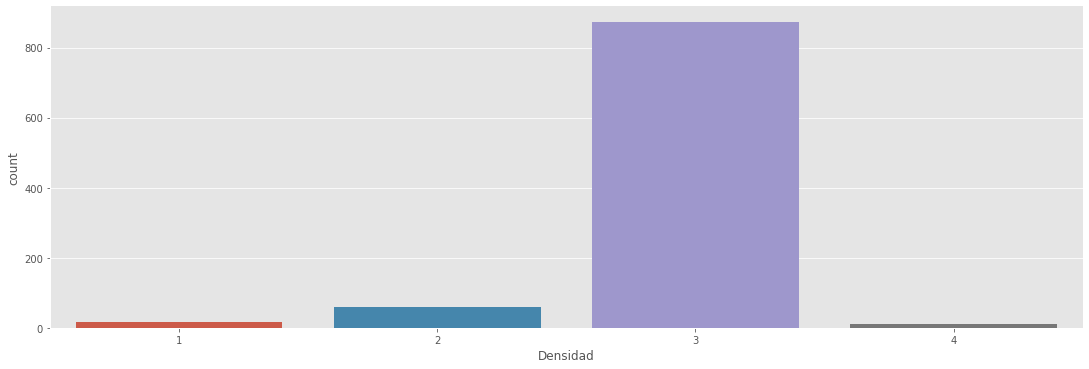

In [25]:
sb.factorplot('Densidad',data=mamm_masses,kind="count", aspect=3)
#Densidad: densidad de la masa high=1 iso=2 low=3 fat-containing=4

La densidad del seno hace una comparación entre el tejido conectivo vs la cantidad de grasa contenida en el mismo, dificultando el primero el detectar el cáncer de seno al obstruir la visibilidad de la radiografía.[4] 

1. Alta
2. Constante
3. Baja
4. Contiene grasa

En la gráfica se puede evidenciar claramente una predominancia de senos con baja densidad, lo cual es común en mujeres que ya pasaron la menopausia, cosa que coincide con que el grueso de la población estudiada ya pasó lo 40 años, edad en la que se suele iniciar dicha etapa.

###Severidad

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


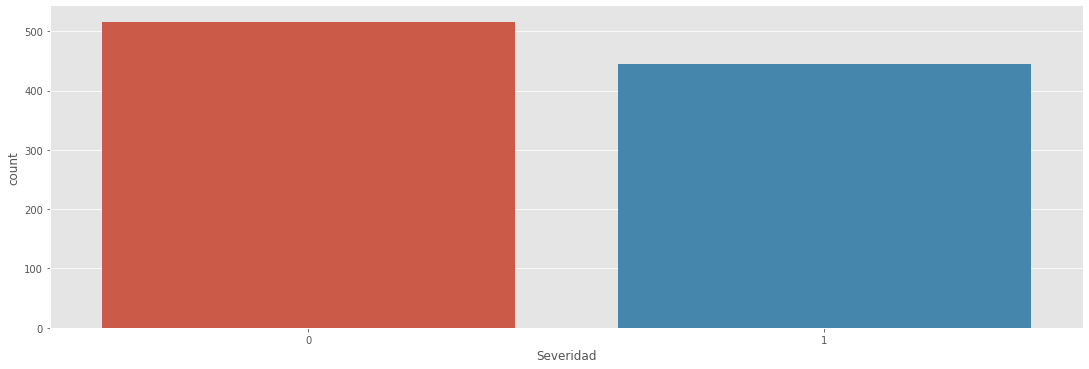

In [26]:
sb.factorplot('Severidad',data=mamm_masses,kind="count", aspect=3)
#Severidad: benigno=0 or maligno=1

Este gráfico permite evidenciar la proporción de casos posivos de tumores o cuerpos malignos en los seños contra los negativos, cosa que si bien nos permite ver que los casos sanos son mayoría, también enseña que este es un mal bastante común en la población estudiada, donde:

1. Benigno
2. Maligno

##Correlación de las variables

Se crea un nuevo nuevo dataframe sacando los datos de edad para dejar solo los rangos de edad anteriormente calculados.

In [27]:
mamm_masses_ready = mamm_masses.drop('Edad', axis = 1)
mamm_masses_ready.describe()

,Mamografia,Forma,Margen,Densidad,Severidad,RangoEdad
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,4.285120,2.762747,2.706556,2.917794,0.463059,3.819979
std,0.664484,1.243276,1.576272,0.365869,0.498893,1.018504
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,4.000000,2.000000,1.000000,3.000000,0.000000,3.000000
50%,4.000000,3.000000,3.000000,3.000000,0.000000,4.000000
75%,5.000000,4.000000,4.000000,3.000000,1.000000,5.000000
max,5.000000,4.000000,5.000000,4.000000,1.000000,6.000000


Y con el nuevo dataset se prosigue a realizar una matriz de correlación entre las diferentes variables

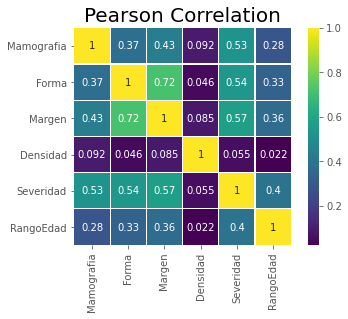

In [28]:
colormap = plt.cm.viridis
plt.title('Pearson Correlation', size=20)
sb.heatmap(mamm_masses_ready.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True,
           )

Según esta gráfica hay una leve correlación entre Forma y Margen, además algunas variables presentan valores medios entre la correlación, como es el caso de Severidad con Mamografía, Forma y Margen. Sin embargo, debido a la naturaleza del problema, ya que es un tema delicado en el que se deben evitar todos los errores posibles, y además tomando en consideración las pocas variables que tiene el dataframe, se decide dejar todas las columnas para la realización del árbol.

#Clasificación usando un árbol de decisiones

A continuación se seleccionarán las variables a utilizar y se creará el árbol para la clasificación

##Selección de características

In [29]:
# Crear arrays para el objetivo y las etiquetas que indican si llegó es benigno o maligno 
Y = mamm_masses_ready['Severidad']
X = mamm_masses_ready.drop(['Severidad'], axis=1).values 

# Dividir los arrays en un 75% entrenamiento y 25% testing 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) 
print("La cantidad de datos de entrenamiento en 'X' son",len(X_train), "y en 'Y' son", len(Y_train))
print("La cantidad de datos de prueba en 'X' son",len(X_test), "y en 'Y' son", len(Y_test))

La cantidad de datos de entrenamiento en 'X' son 720 y en 'Y' son 720
La cantidad de datos de prueba en 'X' son 241 y en 'Y' son 241


Se dividen los datos en datos de entrenamiento y datos de prueba en un procentaje de 75% - 25% respectivamente debido a que la cantidad de datos dele dataframe no es muy grande y este porcentaje de buenos resultados en casi todos los tamaños de dataframes y luego de hacer pruebas notamos que es el que mejor evita el overfitting. Luego se procede a comparar diferentes datos para elegir las mejores características del árbol.

In [30]:
max_attributes = len(list(mamm_masses_ready))
depth_range = range(1, 16)

# Testearemos la profundidad
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             #min_samples_split=10,
                                             #min_samples_leaf=5,
                                             max_depth = depth,
                                             #class_weight={0:5} # Por defecto todas las clases igual peso
    )
    model = tree_model.fit(X_train, Y_train) 
    valid_acc = round(tree_model.score(X_train, Y_train)*100, 2) # Calculamos la precision con los datos de prueba
    
    print("Con profundidad", depth,"la precisión de árbol es:",valid_acc,'%')

Con profundidad 1 la precisión de árbol es: 82.64 %
Con profundidad 2 la precisión de árbol es: 82.64 %
Con profundidad 3 la precisión de árbol es: 84.17 %
Con profundidad 4 la precisión de árbol es: 84.44 %
Con profundidad 5 la precisión de árbol es: 84.86 %
Con profundidad 6 la precisión de árbol es: 85.83 %
Con profundidad 7 la precisión de árbol es: 86.25 %
Con profundidad 8 la precisión de árbol es: 86.39 %
Con profundidad 9 la precisión de árbol es: 86.53 %
Con profundidad 10 la precisión de árbol es: 86.94 %
Con profundidad 11 la precisión de árbol es: 86.94 %
Con profundidad 12 la precisión de árbol es: 86.94 %
Con profundidad 13 la precisión de árbol es: 87.22 %
Con profundidad 14 la precisión de árbol es: 87.22 %
Con profundidad 15 la precisión de árbol es: 87.22 %


Se puede ver que aproximadamente en la profundidad 13 deja de haber mejoría en la precisión del árbol, por esto se toma esta profundidad para el ajuste final del árbol y se usa la métrica 'entropy' porque es la que genera mejores resultados y también los mas estables en nuestro dataframe. 

In [31]:
max_attributes = len(list(mamm_masses_ready))
min_samples_split_range = range(10, 1, -1)

# Testearemos el número mínimo de muestras requeridas para dividir un nodo
for min_samples_s in min_samples_split_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=min_samples_s,
                                             #min_samples_leaf=5,
                                             max_depth = 13,
                                             #class_weight={0:5} # Por defecto todas las clases igual peso
    )
    model = tree_model.fit(X_train, Y_train) 
    valid_acc = round(tree_model.score(X_train, Y_train)*100, 2) # Calculamos la precision con los datos de prueba
    
    print("Con", min_samples_s,"como mínimo numero de muestras, la precisión de árbol es:",valid_acc,'%')

Con 10 como mínimo numero de muestras, la precisión de árbol es: 86.25 %
Con 9 como mínimo numero de muestras, la precisión de árbol es: 86.53 %
Con 8 como mínimo numero de muestras, la precisión de árbol es: 86.53 %
Con 7 como mínimo numero de muestras, la precisión de árbol es: 86.67 %
Con 6 como mínimo numero de muestras, la precisión de árbol es: 86.81 %
Con 5 como mínimo numero de muestras, la precisión de árbol es: 86.94 %
Con 4 como mínimo numero de muestras, la precisión de árbol es: 86.94 %
Con 3 como mínimo numero de muestras, la precisión de árbol es: 86.94 %
Con 2 como mínimo numero de muestras, la precisión de árbol es: 87.22 %


Además, se concluye que el mejor valor para el número mínimo de muestras requeridas para dividir un nodo interno es de 2, es decir, el mínimo permitido por la librería utilizada.

In [32]:
max_attributes = len(list(mamm_masses_ready))
min_samples_leaf_range = range(10, 0, -1)

# Testearemos el número mínimo de muestras requeridas para ser un nodo hoja
for min_samples_l in min_samples_leaf_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split = 2,
                                             min_samples_leaf=min_samples_l,
                                             max_depth = 13,
                                             #class_weight={0:5} # Por defecto todas las clases igual peso
    )
    model = tree_model.fit(X_train, Y_train) 
    valid_acc = round(tree_model.score(X_train, Y_train)*100, 2) # Calculamos la precision con los datos de prueba
    
    print("Con", min_samples_l,"como mínimo numero de hojas, la precisión de árbol es:",valid_acc,'%')

Con 10 como mínimo numero de hojas, la precisión de árbol es: 84.17 %
Con 9 como mínimo numero de hojas, la precisión de árbol es: 84.31 %
Con 8 como mínimo numero de hojas, la precisión de árbol es: 84.31 %
Con 7 como mínimo numero de hojas, la precisión de árbol es: 84.72 %
Con 6 como mínimo numero de hojas, la precisión de árbol es: 84.72 %
Con 5 como mínimo numero de hojas, la precisión de árbol es: 85.0 %
Con 4 como mínimo numero de hojas, la precisión de árbol es: 85.28 %
Con 3 como mínimo numero de hojas, la precisión de árbol es: 85.83 %
Con 2 como mínimo numero de hojas, la precisión de árbol es: 85.83 %
Con 1 como mínimo numero de hojas, la precisión de árbol es: 87.22 %


Por último, se concluye que el mejor valor para el número mínimo de muestras requeridas para ser un nodo hoja es de 1, es decir, el mínimo permitido por la librería utilizada.

In [33]:
acc_decision_tree_train = round(tree_model.score(X_train, Y_train)*100, 2)
print("Precisión de árbol en el entrenamiento:",acc_decision_tree_train,'%')

acc_decision_tree_test = round(tree_model.score(X_test, Y_test)*100, 2)
print("Precisión de árbol en la prueba:",acc_decision_tree_test,'%')

Precisión de árbol en el entrenamiento: 87.22 %
Precisión de árbol en la prueba: 81.74 %


Ahora bien, se hacen pruebas con los pesos del árbol para asegurar el mejor desempeño posible. Para ello se tomará un procedimiento semejante al visto en clase tomando la proporción de los casos de severidad 0 (Sanos) respecto a los de severidad 1 (Casos confirmados). 

516/445 = 1.15

Por ello se usará dicho numero para multiplicar los pesos de las clases

In [34]:
#Se crea un arreglo de pesos alrededor del calculado anteriormente para las pruebas a realizar
weigths_array = [1, 1.05, 1.1, 1.15, 1.2, 1.5, 2, 3]
clase_String = ""

for clase in range(0, 2):  #Se va a ir probando los diversos pesos con cada una de las distintas clases del dataset
  for weigth in weigths_array:
      tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                              max_depth = 13,
                                              class_weight={clase:weigth} 
      )
      model = tree_model.fit(X_train, Y_train) 
      valid_acc = round(tree_model.score(X_train, Y_train)*100, 2) # Calculamos la precision con los datos de prueba
      
      if clase == 0:
        clase_String = "Benigno"
      else:
        clase_String = "Maligno"

      print("Con un peso de ", weigth," en la clase", clase, "(",clase_String,") , la precisión de árbol es:",valid_acc,'%')
  print("\n")

Con un peso de  1  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.05  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.1  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.15  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.2  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.5  en la clase 0 ( Benigno ) , la precisión de árbol es: 87.08 %
Con un peso de  2  en la clase 0 ( Benigno ) , la precisión de árbol es: 86.11 %
Con un peso de  3  en la clase 0 ( Benigno ) , la precisión de árbol es: 85.56 %


Con un peso de  1  en la clase 1 ( Maligno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.05  en la clase 1 ( Maligno ) , la precisión de árbol es: 87.22 %
Con un peso de  1.1  en la clase 1 ( Maligno ) , la precisión de árbol es: 86.81 %
Con un peso de  1.15  en la clase 1 ( Maligno ) , la precisión de árbol es: 86.81 %
Con un

Tomando en cuenta la proporción entre las clases de severidad, que es de casi 1 y las pruebas realizadas, tenemos que el cambiar los pesos no afecta de manera significativa a la presición del árbol. Al contrario, al aumentar el peso de una u otra clase dicho factor se ve afectado negativamente. Por ello podemos concluir que las clases están balanceadas y que no se requiere modificar dicho valor al construir el árbol de decisiones.

###Ajuste CON la variable de Margen
Hacemos un ajuste con todas las variables, inclusive la variable Margen.

In [35]:
# Crear Árbol de decision con profundidad = 13
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', #entropy o gini (entropy suele dar mejor accuracy)
                                            max_depth = 13,
                                            )
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train)*100, 2)
print("Precisión de árbol en el entrenamiento:",acc_decision_tree_train,'%')

acc_decision_tree_test = round(decision_tree.score(X_test, Y_test)*100, 2)
print("Precisión de árbol en la prueba:",acc_decision_tree_test,'%')

Precisión de árbol en el entrenamiento: 87.22 %
Precisión de árbol en la prueba: 81.74 %


Vemos que en el ajuste del árbol el entrenamiento de muy buen resultado con un 87% de acierto, pero a la hora de evaluar la presición en las pruebas el procentaje baja entre un 2% y un 10%, esto puede deberse a un leve overfitting causado por el nivel de correlación entre la variable de Margen y al variable de Forma, por esto se decidió hacer una prueba sacando la variable de Margen.

###Ajuste SIN la variable de Margen
Hacemos un ajuste sacando la variable Margen del dataframe para ver si esto mejora el desempeño y se hace una conclusión.

In [37]:
mamm_masses_ready_alt = mamm_masses_ready.drop('Margen', axis = 1)
mamm_masses_ready_alt.describe()

,Mamografia,Forma,Densidad,Severidad,RangoEdad
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,4.285120,2.762747,2.917794,0.463059,3.819979
std,0.664484,1.243276,0.365869,0.498893,1.018504
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,4.000000,2.000000,3.000000,0.000000,3.000000
50%,4.000000,3.000000,3.000000,0.000000,4.000000
75%,5.000000,4.000000,3.000000,1.000000,5.000000
max,5.000000,4.000000,4.000000,1.000000,6.000000


In [38]:
# Crear arrays para el objetivo y las etiquetas que indican si llegó es benigno o maligno 
Y_alt = mamm_masses_ready_alt['Severidad']
X_alt = mamm_masses_ready_alt.drop(['Severidad'], axis=1).values 

# Dividir los arrays en un 75% entrenamiento y 25% testing 
X_train_alt, X_test_alt, Y_train_alt, Y_test_alt = train_test_split(X_alt, Y_alt, test_size=0.25) 

In [39]:
decision_tree_alt = tree.DecisionTreeClassifier(criterion='entropy', #entropy o gini (entropy suele dar mejor accuracy)
                                            max_depth = 13,
                                            )
decision_tree_alt.fit(X_train_alt, Y_train_alt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
acc_decision_tree_train = round(decision_tree_alt.score(X_train_alt, Y_train_alt)*100, 2)
print("Precisión de árbol en el entrenamiento:",acc_decision_tree_train,'%')

acc_decision_tree_test = round(decision_tree_alt.score(X_test_alt, Y_test_alt)*100, 2)
print("Precisión de árbol en la prueba:",acc_decision_tree_test,'%')

Precisión de árbol en el entrenamiento: 85.97 %
Precisión de árbol en la prueba: 77.59 %


###Conclusión de la selección de características
Luego de sacar la variable de Margen notamos que en la mayoría de las corridas esto empeoró los resultados y cuando los mejoraba no eran lo suficientemente significativos como para sacrificr una variable, por lo que se decide dejarla en el dataframe.
Los resultados obtenidos de las pruebas para la elección de los parámetros se deben a que el dataframe es relatiamente pequeño, por lo que cada parte de la información es útil, por eso la profundidad es tan alta y los valores mínimos requeridos para la división de nodos y creación de nodos hoja son los menores posibles.
En síntesis, se usa una proifundidad de 12, un mínimo de muestras para dividir un nodo de 2 y un mínimo de muestras para nodo hoja de 1.



##Ajuste y gráfica del árbol



Luego de hacer varias pruebas y comparaciones se eligen las características del árbol que dieron mejores resultados y procedemos establecer y graficar el árbol final.

In [41]:
# Crear Árbol de decision con profundidad = 13
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', #entropy o gini (entropy suele dar mejor accuracy)
                                            max_depth = 13,
                                            )
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

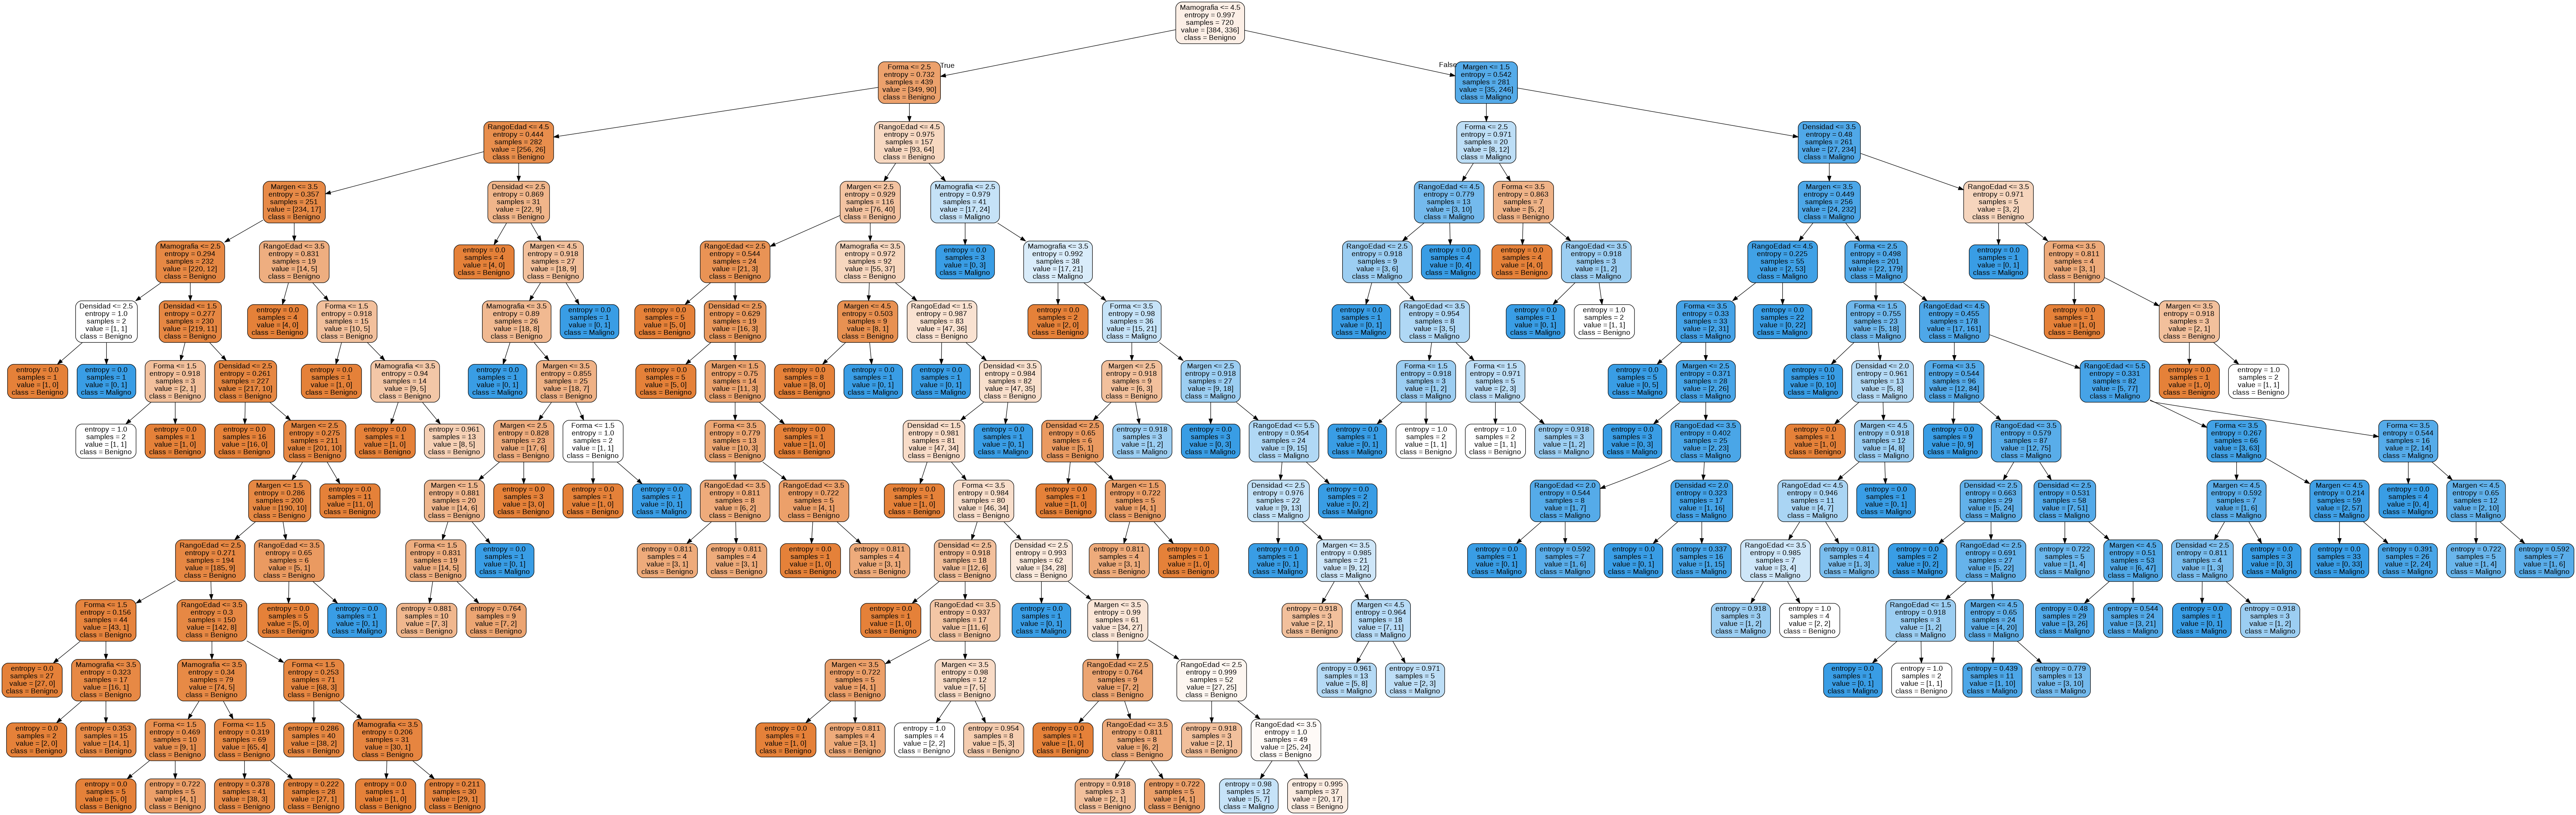

In [42]:
# Mostrar árbol elegido
# exportar el modelo a archivo .dot
with open(r"tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              impurity = True,
                              feature_names = list(mamm_masses_ready.drop(['Severidad'], axis=1)),
                              class_names = ['Benigno', 'Maligno'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree.dot','-o',r'tree.png'])
PImage("tree.png")

Podemos ver el que el nodo raíz es la variable "Mamografía", además, si bien se evidencian unas cuantas hojas con valores bajos de entropía, se ven otras cuantas con valores muy alto, la mayoría llegando casi a ser de 1.0, lo cual sumado a la exactitud del árbol vista anteriormente nos permite concluir que este tiene un buen desempeño.

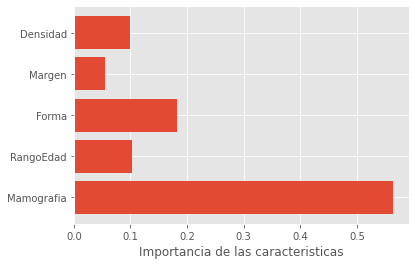

In [43]:
#Se mira el orden de prioridad que el árbol le da a las diferentes caracteristicas
caract = 5
plt.barh(range(caract), model.feature_importances_)
plt.yticks(np.arange(caract),['Mamografia','RangoEdad','Forma','Margen','Densidad'])
plt.xlabel('Importancia de las caracteristicas')
plt.show()

In [44]:
# Se muestra la cantidad de muestras malignas y benignas respecto a el grupo de Mamografia

var1 = ((mamm_masses_ready['Mamografia'] == 5) & (mamm_masses_ready['Severidad'] == 1)).sum()
var2 = ((mamm_masses_ready['Mamografia'] == 5) & (mamm_masses_ready['Severidad'] == 0)).sum()

print('Numero de mamografías en el grupo 5 Malignas son',var1,'con un porcentaje de:',round(var1/(var1+var2)*100,2),'% en un grupo de', var1+var2, 'muestras')
print('Numero de mamografías en el grupo 5 Benignas son',var2,'con un porcentaje de:',round(var2/(var1+var2)*100,2),'% en un grupo de', var1+var2, 'muestras \n')

var3 = ((mamm_masses_ready['Mamografia'] == 4) & (mamm_masses_ready['Severidad'] == 1)).sum()
var4 = ((mamm_masses_ready['Mamografia'] == 4) & (mamm_masses_ready['Severidad'] == 0)).sum()

print('Numero de mamografías en el grupo 4 Malignas son',var3,'con un porcentaje de:',round(var3/(var3+var4)*100,2),'% en un grupo de', var3+var4, 'muestras')
print('Numero de mamografías en el grupo 4 Benignas son',var4,'con un porcentaje de:',round(var4/(var3+var4)*100,2),'% en un grupo de', var3+var4, 'muestras')

Numero de mamografías en el grupo 5 Malignas son 314 con un porcentaje de: 87.96 % en un grupo de 357 muestras
Numero de mamografías en el grupo 5 Benignas son 43 con un porcentaje de: 12.04 % en un grupo de 357 muestras 

Numero de mamografías en el grupo 4 Malignas son 120 con un porcentaje de: 21.94 % en un grupo de 547 muestras
Numero de mamografías en el grupo 4 Benignas son 427 con un porcentaje de: 78.06 % en un grupo de 547 muestras


Vemos entre las personas que tuvieron una mamografía en el grupo 5, el 88% son malignas, este porcentaje es sacado de una gran cantidad de personas, lo que aumenta su credibilidad, por esta razón se toma el grupo de la mamografía como el nodo raíz, ya que es un factor muy significativo en la predicción, además, por debajo de 5 la mayoría de las mamografías son benignas.

In [45]:
# Se muestra la cantidad de muestras malignas y benignas respecto a el grupo de RangoEdad

var1 = ((mamm_masses_ready['RangoEdad'] == 6) & (mamm_masses_ready['Severidad'] == 1)).sum()
var2 = ((mamm_masses_ready['RangoEdad'] == 6) & (mamm_masses_ready['Severidad'] == 0)).sum()

print('Numero de mamografías en el grupo etareo 6 Malignas son',var1,'con un porcentaje de:',round(var1/(var1+var2)*100,2),'% en un grupo de', var1+var2, 'muestras')
print('Numero de mamografías en el grupo etareo 6 Benignas son',var2,'con un porcentaje de:',round(var2/(var1+var2)*100,2),'% en un grupo de', var1+var2, 'muestras \n')

var3 = ((mamm_masses_ready['RangoEdad'] == 4) & (mamm_masses_ready['Severidad'] == 1)).sum()
var4 = ((mamm_masses_ready['RangoEdad'] == 4) & (mamm_masses_ready['Severidad'] == 0)).sum()

print('Numero de mamografías en el grupo etareo 4 Malignas son',var3,'con un porcentaje de:',round(var3/(var3+var4)*100,2),'% en un grupo de', var3+var4, 'muestras')
print('Numero de mamografías en el grupo etareo 4 Benignas son',var4,'con un porcentaje de:',round(var4/(var3+var4)*100,2),'% en un grupo de', var3+var4, 'muestras \n')

var5 = ((mamm_masses_ready['RangoEdad'] == 2) & (mamm_masses_ready['Severidad'] == 1)).sum()
var6 = ((mamm_masses_ready['RangoEdad'] == 2) & (mamm_masses_ready['Severidad'] == 0)).sum()

print('Numero de mamografías en el grupo etareo 4  Malignas son',var5,'con un porcentaje de:',round(var5/(var5+var6)*100,2),'% en un grupo de', var5+var6, 'muestras')
print('Numero de mamografías en el grupo etareo 4 Benignas son',var6,'con un porcentaje de:',round(var6/(var5+var6)*100,2),'% en un grupo de', var5+var6, 'muestras')

Numero de mamografías en el grupo etareo 6 Malignas son 25 con un porcentaje de: 89.29 % en un grupo de 28 muestras
Numero de mamografías en el grupo etareo 6 Benignas son 3 con un porcentaje de: 10.71 % en un grupo de 28 muestras 

Numero de mamografías en el grupo etareo 4 Malignas son 170 con un porcentaje de: 46.7 % en un grupo de 364 muestras
Numero de mamografías en el grupo etareo 4 Benignas son 194 con un porcentaje de: 53.3 % en un grupo de 364 muestras 

Numero de mamografías en el grupo etareo 4  Malignas son 7 con un porcentaje de: 8.14 % en un grupo de 86 muestras
Numero de mamografías en el grupo etareo 4 Benignas son 79 con un porcentaje de: 91.86 % en un grupo de 86 muestras


Aquí se puede evidenciar el orden de prioridad de las caracteristicas del árbol anterior a la hora de clasificar los casos reportados, se puede evidenciar que le presta especial atención a la variable *Mamográfia*, por ende es el nodo raíz, cosa que tiene bastante sentido si tomamos como base la suposición que se hizo al principio de este trabajo, pues un estandar médico previo es una gran ayuda a la hora de clasificar los pacientes. Tenemos que a esa variable le sigue en importancia la *Edad*, pues el cáncer de mama suele ser más común en mujeres mayores que en jóvenes, por lo que esto también es una buena base al decidir. 

Todo ello para después tomar en cuenta la *Forma* y la *Densidad*, las cuales tienen un nivel de importancia similar, cada una contribuyendo a su manera a la clasificación, debido a los aspectos anteriormente mencionados, para finalizar con la *Margen*, cosa entendible pues esta puede verse afectada por otras como la densidad. Además, aunque una margen espiculada suele ser una de las manifestaciones más comunes del cáncer de mama, no es un sintoma decisivo en el diagnostico.

##Medidas de desempeño

In [46]:
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train)*100, 2)
print("Precisión de árbol en el entrenamiento:",acc_decision_tree_train,'%')

acc_decision_tree_test = round(decision_tree.score(X_test, Y_test)*100, 2)
print("Precisión de árbol en la prueba:",acc_decision_tree_test,'%')

Precisión de árbol en el entrenamiento: 87.22 %
Precisión de árbol en la prueba: 81.33 %


In [47]:
Y_pred = decision_tree.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

[[115  17]
 [ 28  81]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       132
           1       0.83      0.74      0.78       109

    accuracy                           0.81       241
   macro avg       0.82      0.81      0.81       241
weighted avg       0.81      0.81      0.81       241



##Calsificación de un caso especifico

In [48]:
x_test = pd.DataFrame(columns=('Mamografia','RangoEdad','Forma','Margen','Densidad','Severidad'))
x_test.loc[0] = (5,4,4,5,3,1)
y_pred = decision_tree.predict(x_test.drop(['Severidad'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['Severidad'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [100.]%


In [49]:
x_test = pd.DataFrame(columns=('Mamografia','RangoEdad','Forma','Margen','Densidad','Severidad'))
x_test.loc[0] = (5,1,1,1,1,0)
y_pred = decision_tree.predict(x_test.drop(['Severidad'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['Severidad'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [100.]%


#Clasificación Bayesiana

A continuación se hará la clasificación del dataset anterior por medio del algoritmo Bayesiano

##Distribuión y correlación de las variables

Primero que todo se pretende observar la distribución de los datos que se tienen

In [50]:
print(mamm_masses_ready.groupby('Severidad').size())
mamm_masses_ready.shape

Severidad
0    516
1    445
dtype: int64


(961, 6)

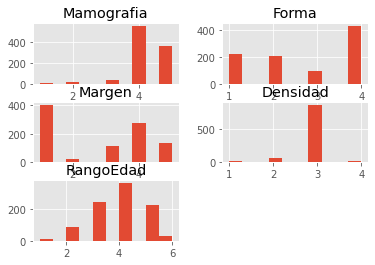

In [51]:
mamm_masses_ready.drop(['Severidad'], axis=1).hist()
plt.show()

Se puede observar una probable distribución normal en la variable RangoEdad, además de una posible en Densidad y Mamografía. Sin embargo, se pretenderá que todas tienen dicha distribución para fines del método a utilizar. 

##Selección de caracteristicas
A través del método SelectKBest de SKLearn se identificarán las variables más importantes a la hora de llevar a cabo la clasificación

In [52]:
Y_Bayes = mamm_masses_ready['Severidad']
X_Bayes = mamm_masses_ready.drop(['Severidad'], axis=1)

best=SelectKBest(k=4)
X_new = best.fit_transform(X_Bayes, Y_Bayes)
selected = best.get_support(indices=True)
print(X_Bayes.columns[selected])
X_new.shape

Index(['Mamografia', 'Forma', 'Margen', 'RangoEdad'], dtype='object')


(961, 4)

Se seleccionan las 4 variables más importantes para evitar el posible "ruido" que podría afectar en la clasificación sin crear una "visión de tunel" sobre el algoritmo al dejarle con 3 variables o menos.

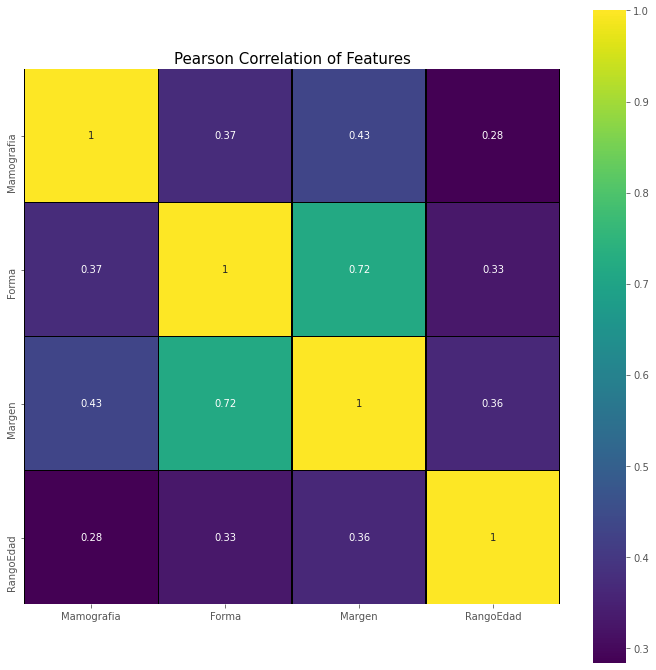

In [53]:
used_features =X_Bayes.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', size=15)
sb.heatmap(mamm_masses_ready[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=True)

En la matriz anterior se puede evidenciar una cierta correlación entre las variables Forma y Margen, pero por bien del método Bayesiano se supondrán completamente independientes entre sí, además, si lo comparamos con la gráfica de correlación de pearson hecha anteriormente, notamos que la variable que sacó la función fue la de Densidad, es decir, la que tenía menor correlación con las demás variables, esto se debe a que este método, al ser ingenua, supone que ninguna de las variables están correlacionadas.



##Definición de los conjuntos de entrenamiento y evaluación
Al igual que en el método anterior, se usará una una distribución 75% - 25% para el entrenamiento y la evaluación respectivamente.

In [54]:
# Dividir los arrays en un 75% entrenamiento y 25% testing 
X_train_b, X_test_b = train_test_split(mamm_masses_ready, test_size=0.25, random_state=6) 
Y_train_b = X_train_b["Severidad"]
Y_test_b = X_test_b["Severidad"]

##Creación del modelo

In [55]:
# Inicializar el clasificador
gnb = GaussianNB()
# Entreenar el clasificador
gnb.fit(
    X_train_b[used_features].values,
    Y_train_b
)
y_pred = gnb.predict(X_test_b[used_features])
 
print('Presición en el entrenamiento:', round(gnb.score(X_train_b[used_features], Y_train_b)*100, 2),'%')
print('Presición con los datos de prueba:', round(gnb.score(X_test_b[used_features], Y_test_b)*100, 2),'%')

Presición en el entrenamiento: 82.22 %
Presición con los datos de prueba: 83.4 %


##Comparación de resultados
Podemos ver que al evaluar el entrenamiento la técnica del árbol de decisión da mejores resultados, pero a la hora de evaluar el desempeño la técnica Bayesiana da mejores resultados, lo que puede llevar a pensar que la técnica Bayesiana sea la mejor para este caso, ya que es más importante considerar como se va a comportar la predicción con los datos ingresados por el usuario. La bajada de desempeño en el árbol de decisión se puede deber a algún problema de mínimo overfitting causado por una posible correlación entre algunas variables, como es el caso de margen y forma o también porque no todas las varaibles se distribuyen de manera normal como se da por supuesto al usar este método.

#Conclusiones generales
1. Debido al tamaño del dataset se debe tomar el árbol más grande posible para que en el entrenamiento se puedan tener en cuenta todas las variables, además. a diferencia de un dataframe de cientas o miles de variables, en este dataframe la inclusión o exclusión de una variable puede generar cambios muy significativos, incluso si la variable es la menosimportante en el entrenamiento.
2. Gracias a que en el árbol de decisión todas las variables son tenidas en cuenta, se puede dar un leve overfitting entre algunas de ellas, pero este resultado sigue siendo mejor que el que obtendríamos sacando alguna de las variables por lo mencionado en el punto anterior.
3. Las predicciones suelen tener uan seguridad de 0%, 50% o 100%, esto puede deberse a que todas nuestras variables están en el rango de 1 a 6, por lo que la mayoría de casos usados para hacer la prueba probablemente se encuentran ya en el dataframe.

#Bibliografía
[1] American Cancer Society. Cómo entender su informe de mamograma. Recuperado de: https://www.cancer.org/es/cancer/cancer-de-seno/pruebas-de-deteccion-y-deteccion-temprana-del-cancer-de-seno/mamogramas/como-entender-su-informe-de-mamograma.html

[2] guiainfantil. Qué es una mamografía y cuándo hay que realizarla. Recuperado de: https://www.guiainfantil.com/articulos/salud/que-es-una-mamografia-y-cuando-hay-que-realizarla/#:~:text=Hay%20mucha%20controversia%20sobre%20cu%C3%A1ndo,los%2040%20a%C3%B1os%20de%20edad.

[3] Radiología para estudiantes. Recuperado de: https://sites.google.com/site/radiologiaparaestudiantes/home/mama/caso-1-nodulo-espiculado

[4] Susan G. Komen. La densidad en los senos. Recuperado de: https://ww5.komen.org/uploadedFiles/_Komen/Content/About_Breast_Cancer/Tools_and_Resources/Translated_Materials/Breast%20Density%20KO2072%20FINAL%20SPA%202-16%20HR.pdf

[5] SEDIM. CAPÍTULO 2. INTERPRETACIÓN RADIOLÓGICA EN PATOLOGÍA MAMARIA. Recuperdo de: http://www.sedim.es/nueva/wp-content/uploads/2015/01/Cap%C3%ADtulo_2_Interpretaci%C3%B3n.compressed.pdf